In [1]:
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn

## Load and Preprocess Data
Really just load and interpolate the current onto the same s.

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

# data = random.choices(data, k=960)

data = [{"s": sample["s"],
         "current": sample["I"],
         "frequencies": sample["freq"],
         "formfactor": sample["formfactor"]} for sample in data]

In [3]:
len(data)

79200

In [4]:
s_min = np.concatenate([sample["s"] for sample in data]).min()
s_max = np.concatenate([sample["s"] for sample in data]).max()
s_min, s_max

(-0.0007414007974541548, 0.0007591195528889543)

In [5]:
sample_indicies = [1, 42, 324]

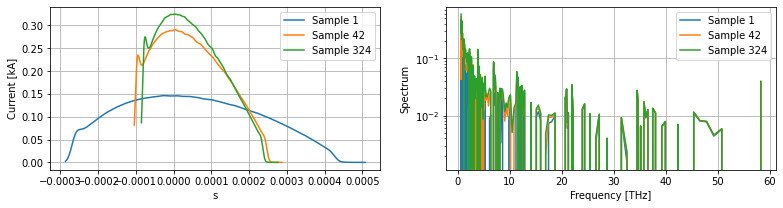

In [6]:
plt.figure(figsize=(13,3))

plt.subplot(121)
for i in sample_indicies:
    plt.plot(data[i]["s"], data[i]["current"]*1e-3, label=f"Sample {i}")
plt.xlabel("s")
plt.ylabel("Current [kA]")
plt.legend()
plt.grid()
    
plt.subplot(122)
for i in sample_indicies:
    plt.plot(data[i]["frequencies"]*1e-12, data[i]["formfactor"], label=f"Sample {i}")
plt.yscale("log")
plt.xlabel("Frequency [THz]")
plt.ylabel("Spectrum")
plt.legend()
plt.grid()

plt.show()

In [7]:
# new_s = np.linspace(-0.00075, 0.00075, 100)
new_s = np.linspace(-0.0003, 0.0003, 1000)

for i in range(len(data)):
    data[i]["current"] = np.interp(new_s, data[i]["s"], data[i]["current"], left=0, right=0)
    data[i]["s"] = new_s

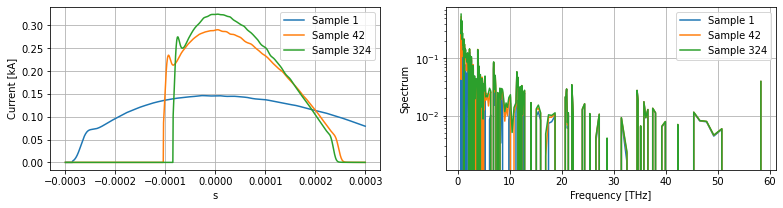

In [8]:
plt.figure(figsize=(13,3))

plt.subplot(121)
for i in sample_indicies:
    plt.plot(data[i]["s"], data[i]["current"]*1e-3, label=f"Sample {i}")
plt.xlabel("s")
plt.ylabel("Current [kA]")
plt.legend()
plt.grid()
    
plt.subplot(122)
for i in sample_indicies:
    plt.plot(data[i]["frequencies"]*1e-12, data[i]["formfactor"], label=f"Sample {i}")
plt.yscale("log")
plt.xlabel("Frequency [THz]")
plt.ylabel("Spectrum")
plt.legend()
plt.grid()

plt.show()

In [9]:
formfactors = np.stack([sample["frequencies"] for sample in data])
formfactors.shape

(79200, 240)

In [10]:
currents = np.stack([sample["current"] for sample in data])
currents.shape

(79200, 1000)

## Create PyTorch Model

In [11]:
epochs = 100
batch_size = 64

In [12]:
formfactor_scaler = MinMaxScaler()
scaled_formfactors = formfactor_scaler.fit_transform(formfactors)

current_scaler = MinMaxScaler()
scaled_currents = current_scaler.fit_transform(currents)

In [31]:
scaled_formfactors.min(), scaled_formfactors.max()

(0.0, 0.0)

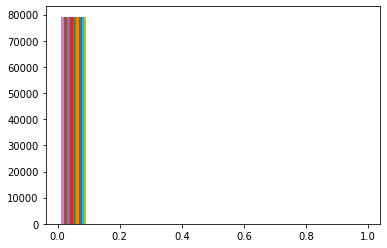

In [32]:
plt.hist(scaled_formfactors, bins=10, range=[0,1])
plt.show()

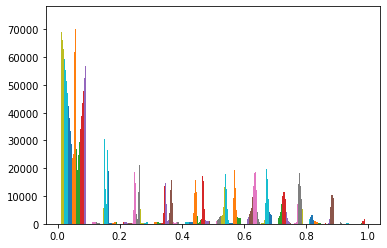

In [33]:
plt.hist(scaled_currents, bins=10, range=[0,1])
plt.show()

In [13]:
new_length = int(len(formfactors) / batch_size) * batch_size

shortened_formfactors = scaled_formfactors[:new_length]
shortened_currents = scaled_currents[:new_length]

In [14]:
torched_formfactors = torch.tensor(shortened_formfactors, dtype=torch.float32)
torched_currents = torch.tensor(shortened_currents, dtype=torch.float32)

In [15]:
training_data = lambda : zip(torch.reshape(torched_formfactors, (-1,64,240)),
                             torch.reshape(torched_currents, (-1,64,1000)))

In [16]:
model = nn.Sequential(nn.Linear(240, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Linear(100, 50),
                      nn.ReLU(),
                      nn.Linear(50, 1000))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

## Training

In [17]:
losses = []

for i in range(epochs):
    for batch, (X, y) in enumerate(training_data()):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"\rEpoch {i}: loss={loss.item()}", end="")
    losses.append(loss.item())

Epoch 99: loss=0.062397766858339314

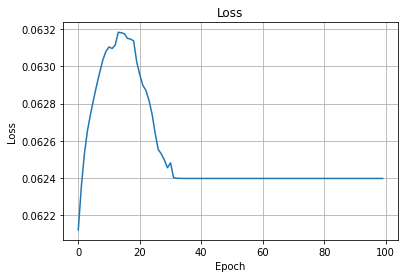

In [18]:
plt.title("Loss")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

## Quick Test

In [19]:
X = np.stack([data[i]["formfactor"] for i in sample_indicies])
Xs = formfactor_scaler.transform(X)
Xt = torch.tensor(Xs, dtype=torch.float32)

y = np.stack([data[i]["current"] for i in sample_indicies])
yt = torch.tensor(y, dtype=torch.float32)

predictions = model(Xt)
predictionss = predictions.detach().numpy()
predictionsn = current_scaler.inverse_transform(predictionss)

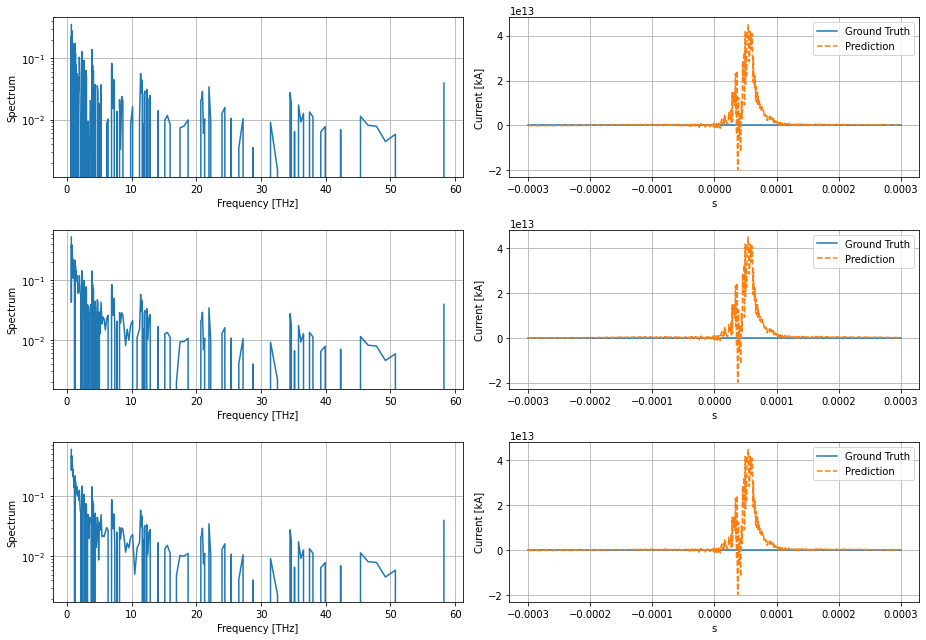

In [20]:
plt.figure(figsize=(13,9))
for i in range(len(X)):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(data[0]["frequencies"]*1e-12, X[i])
    plt.yscale("log")
    plt.xlabel("Frequency [THz]")
    plt.ylabel("Spectrum")
    plt.grid()
    
    plt.subplot(3, 2, 2*i+2)
    plt.plot(data[0]["s"], y[i]*1e-3, label="Ground Truth")
    plt.plot(data[0]["s"], predictionsn[i]*1e-3, "--", label="Prediction")
    plt.xlabel("s")
    plt.ylabel("Current [kA]")
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()